# TP SVM et Machines à Noyaux
### Antoine Desjardins
##### 10 Mai 2020

Dans tout le TP, on utilisera les notation suivantes :  
— A = {xi
, yi} : Ensemble d’apprentissage composé d’exemple $x_i$ associés aux labels $y_i$  
— $X = [x_i], Y = [y_i]$ : Exemples et labels sous forme matricielle (concaténées)  
— $f(x)$ : Fonction de décision  
— $f(x) = <w, x> + b$ dans le cas linéaire  
— $f(x) = \sum_i α_iy_ik(x_i, x)$ dans le cas non linéaire, avec $k(·, ·)$ une fonction noyau  
— $η$ : pas d’apprentissage dans les méthodes de gradient   
— $C = \frac{1}{nλ}$ : Relation d’équivalence entre le compromis de régularisation dans le problème primal et le compromis de régularisation dans le problème dual

# Get Data and load packages

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import preprocessing
from google.colab import files
from sklearn.metrics import hinge_loss
from sklearn import decomposition

import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

np.random.seed(1234)

In [ ]:
files.upload()

Saving data.csv to data.csv


{'data.csv': b'date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country\r\n2014-05-02 00:00:00,313000.0,3.0,1.5,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA\r\n2014-05-02 00:00:00,2384000.0,5.0,2.5,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA\r\n2014-05-02 00:00:00,342000.0,3.0,2.0,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA\r\n2014-05-02 00:00:00,420000.0,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA\r\n2014-05-02 00:00:00,550000.0,4.0,2.5,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA\r\n2014-05-02 00:00:00,490000.0,2.0,1.0,880,6380,1.0,0,0,3,880,0,1938,1994,522 NE 88th St,Seattle,WA 98115,USA\r\n2014-05-02 00:00:00,335000.0,2.0,2.0,1350,2560,1.0,0,0,3,1350,0,1976,0,2616 174th Ave NE,Redmond,WA 98052,USA\r\n2014-05-02

In [ ]:
data = pd.read_csv('data.csv')

In [ ]:
data

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,sqft_above,sqft_basement,yr_built,yr_renovated,street,city,statezip,country
0,2014-05-02 00:00:00,3.130000e+05,3.0,1.50,1340,7912,1.5,0,0,3,1340,0,1955,2005,18810 Densmore Ave N,Shoreline,WA 98133,USA
1,2014-05-02 00:00:00,2.384000e+06,5.0,2.50,3650,9050,2.0,0,4,5,3370,280,1921,0,709 W Blaine St,Seattle,WA 98119,USA
2,2014-05-02 00:00:00,3.420000e+05,3.0,2.00,1930,11947,1.0,0,0,4,1930,0,1966,0,26206-26214 143rd Ave SE,Kent,WA 98042,USA
3,2014-05-02 00:00:00,4.200000e+05,3.0,2.25,2000,8030,1.0,0,0,4,1000,1000,1963,0,857 170th Pl NE,Bellevue,WA 98008,USA
4,2014-05-02 00:00:00,5.500000e+05,4.0,2.50,1940,10500,1.0,0,0,4,1140,800,1976,1992,9105 170th Ave NE,Redmond,WA 98052,USA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4595,2014-07-09 00:00:00,3.081667e+05,3.0,1.75,1510,6360,1.0,0,0,4,1510,0,1954,1979,501 N 143rd St,Seattle,WA 98133,USA
4596,2014-07-09 00:00:00,5.343333e+05,3.0,2.50,1460,7573,2.0,0,0,3,1460,0,1983,2009,14855 SE 10th Pl,Bellevue,WA 98007,USA
4597,2014-07-09 00:00:00,4.169042e+05,3.0,2.50,3010,7014,2.0,0,0,3,3010,0,2009,0,759 Ilwaco Pl NE,Renton,WA 98059,USA
4598,2014-07-10 00:00:00,2.034000e+05,4.0,2.00,2090,6630,1.0,0,0,3,1070,1020,1974,0,5148 S Creston St,Seattle,WA 98178,USA


# Preprocessing
Convert date to int

In [ ]:
data['date_int'] = pd.to_datetime(data['date']).dt.strftime("%Y%m%d").astype(int)

Convert cities to one hot

In [ ]:
city = pd.get_dummies(pd.Categorical(data['city']), prefix='city')

convert observation to numpy

In [ ]:
X = np.concatenate([data[['date_int', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated']].to_numpy(), city.to_numpy()], axis=1)

In [ ]:
X.shape

(4600, 57)

convert price to numpy

In [ ]:
Y = data['price'].to_numpy()
Y.shape
print(Y)

[ 313000.       2384000.        342000.       ...  416904.166667
  203400.        220600.      ]


split train/val/test sets

In [ ]:
r = np.random.permutation(len(X))
X_train = X[r[0:3500], :]
Y_train = Y[r[0:3500]]
X_val = X[r[3500:4000], :]
Y_val = Y[r[3500:4000]]
X_test = X[r[4000:], :]
Y_test = Y[r[4000:]]

# Cas Linéaire

On s’intéresse dans un premier temps au cas linéaire :  
$\displaystyle min_{w,b} \frac{\lambda}{2} ||w||^2 + \frac{1}{n} \sum_i l(y_i,f(x_i))
$  
Avec la fonction de prédiction linéaire suivante :  
$f(x) = <w, x> + b $  
Où $w$ est le vecteur normal à l’hyperplan défini par $f(x) = 0$ et $b$ est le biais. Pour cela, nous allons utiliser l’algorithme SAG défini dans :
Roux, Nicolas L., Mark Schmidt, and Francis R. Bach. *”A stochastic gradient method with an exponential
convergence rate for finite training sets.”* In Advances in neural information processing systems, pp. 2663-2671. 2012.

## Classification
Programmez l’algorithme SAG en python pour le *hinge loss* $(l(x, y) = max(0, 1−yf(x))$.

In [ ]:
class  SAGClassifier():
  def  __init__(self , lambada=0.001 , eta=0.01):
    self.lambada = lambada
    self.eta = eta
    self.w = None
    self.b = None
    self.hingeloss = []
    
  def fit (self, X, Y, epochs =5):
    # afin de simplifier les calculs on va ajouter une colonne de 1 a X
    X1 = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
    n, p = X1.shape
    direction = np.zeros(p)
    y = np.zeros((n,p))
    for i in range(epochs):
      # cas premier passage, on initie aleatoirement
      if self.w is None:
        self.w = np.random.random(p)
      # toujours pour simplifier le calcul
      else:
        self.w = np.concatenate((np.array([self.b]), self.w))
      batch = np.random.permutation(n)
      m = 0 # compteur, converge vers n
      for j in batch:
        m += 1
        # etape 1
        direction -= y[j]
        # etape 2
        y[j] = self.lambada*self.w
        # derivee de la hinge_loss
        if Y[j]*(X1[j].T@self.w)<1:
          y[j] -= Y[j]*X1[j]
        # etape 3
        direction += y[j]
        # etape 4
        self.w = (1-self.eta*self.lambada)*self.w - (self.eta/m)*direction
      self.b = self.w[0]
      self.w = self.w[1:]
      self.hingeloss.append(sklearn.metrics.hinge_loss(self.predict(X),Y))
  

  def predict (self, X):
    return np.where(X@self.w +self.b>0,1,-1)


##### 1. Testez votre implémentation sur un cas jouet en 2 dimensions, composé d’une gaussienne en (0,0) et d’une autre gaussienne en (1,1). Visualisez les exemples d’apprentissage, les zones de prédiction de chaque classe ainsi que la frontière entre les classes

Text(0.5, 1.0, '2 Gaussiennes centrées en (0,0) et (1,1)')

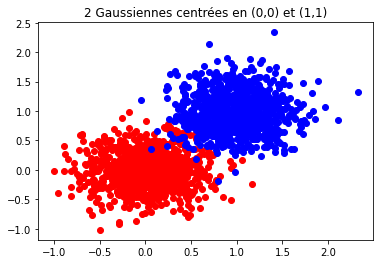

In [ ]:
# nombre de points par gaussienne n
n = 1000
# matrice de covariance (2,2)
cov = 0.1*np.eye(2)

Gauss0 = np.random.multivariate_normal([0,0], cov, n)
Gauss1 = np.random.multivariate_normal([1,1], cov, n)
Gauss = np.concatenate((Gauss0,Gauss1))
Labels = np.concatenate((-np.ones(n),np.ones(n)))

plt.figure
plt.scatter(Gauss0[:,0],Gauss0[:,1],c ='r')
plt.scatter(Gauss1[:,0],Gauss1[:,1],c='b')
plt.title('2 Gaussiennes centrées en (0,0) et (1,1)')

In [ ]:
nb_epochs = 40
SAG = SAGClassifier()
SAG.fit(Gauss,Labels,epochs=nb_epochs)
print('w = ', SAG.w,' et b = ',SAG.b)

w =  [35.16233165 37.70749413]  et b =  -35.78557630040677


Text(0.5, 1.0, '2 Gaussiennes centrées en (0,0) et (1,1)')

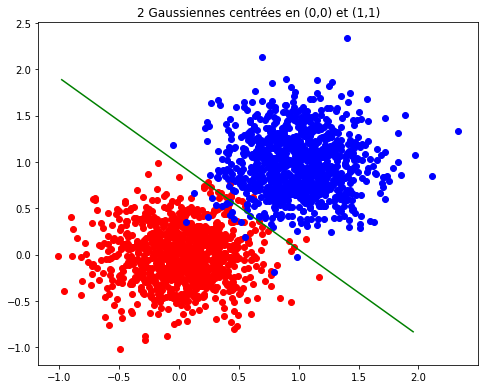

In [ ]:
wnew = 2*np.array([SAG.w[1], -SAG.w[0]])/np.linalg.norm(SAG.w)
lesx = SAG.w*(-SAG.b/(np.linalg.norm(SAG.w)**2)) + wnew
lesy = SAG.w*(-SAG.b/(np.linalg.norm(SAG.w)**2)) - wnew

plt.figure
plt.scatter(Gauss0[:,0],Gauss0[:,1],c ='r')
plt.scatter(Gauss1[:,0],Gauss1[:,1],c='b')
plt.plot([pts1[0], pts2[0]], [pts1[1], pts2[1]], color='g')
plt.title('2 Gaussiennes centrées en (0,0) et (1,1)')

La régression semble bien fonctionner !

##### 2. Assurez-vous que votre implémentation supporte des *warm start*, c’est-à-dire que la méthode `fit(X, Y)` ne ré-initialise pas les paramètres *w* et *b*, mais continue à optimiser à partir de l’état courant. Tracer la courbe de l’évolution du *hinge loss* en fonction des époques.

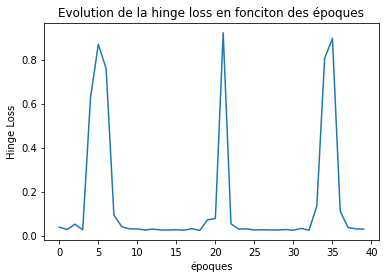

In [ ]:
plt.figure
plt.plot(np.arange(nb_epochs),SAG.hingeloss)
plt.title('Evolution de la hinge loss en fonciton des époques')
plt.xlabel('époques')
plt.ylabel('Hinge Loss')
plt.show()

##### 3. Faire de même en fonction du pas d’apprentissage *η* et du critère de régularisation *λ*.

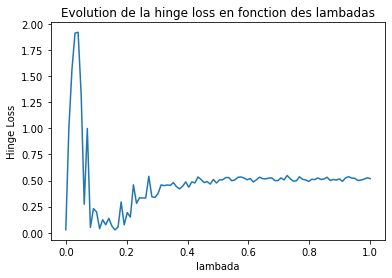

In [ ]:
hingeloss = []
lambada_range = np.linspace(0.0001, 1, 100)
for lambada_local in lambada_range:
  SAG = SAGClassifier(lambada = lambada_local)
  SAG.fit(Gauss,Labels)
  hingeloss.append(sklearn.metrics.hinge_loss(Labels,SAG.predict(Gauss)))

plt.figure
plt.plot(lambada_range,hingeloss)
plt.title('Evolution de la hinge loss en fonction des lambadas')
plt.xlabel('lambada')
plt.ylabel('Hinge Loss')
plt.show()

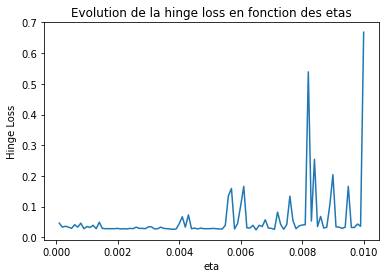

In [ ]:
hingeloss = []
eta_range = np.linspace(0.0001, 0.01, 100)
for eta_local in eta_range:
  SAG = SAGClassifier(eta = eta_local)
  SAG.fit(Gauss,Labels)
  hingeloss.append(sklearn.metrics.hinge_loss(Labels,SAG.predict(Gauss)))

plt.figure
plt.plot(eta_range, hingeloss)
plt.title('Evolution de la hinge loss en fonction des etas')
plt.xlabel('eta')
plt.ylabel('Hinge Loss')
plt.show()

##### 4. Utilsez votre algorithme pour classifier le jeu de données *housedata* en deux classes séparant les biens valant plus de $460k de ceux de moins de \$460k Quelles performances obtenez vous ? Pour quels paramètres, avec quels prétraitements (normalisation, standardisation, PCA, etc) ?

In [ ]:
def separation(Y_local, Y_total):
  return np.where(Y_local > np.median(Y_total),1,-1)

Y_train_2 = separation(Y_train,Y)
Y_test_2 = separation(Y_test,Y)
Y_val_2 = separation(Y_val,Y)

In [ ]:
lambada = 0.1
eta = 0.01
epochs = 1

SAG = SAGClassifier(lambada = lambada, eta = eta)
SAG.fit(X_train,Y_train_2, epochs = epochs)
# print('w = ', SAG.w,' et b = ',SAG.b)

print('Taux d\'erreur = ', 100*sum(abs(Y_train_2 - SAG.predict(X_train))/(2*len(Y_train_2))), '%')

Taux d'erreur =  50.14285714285628 %


In [ ]:
# standardisation
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)
X_val_std = scaler.transform(X_val)

In [ ]:
lambada = 0.1
eta = 0.01
epochs = 1

SAG = SAGClassifier(lambada = lambada, eta = eta)
SAG.fit(X_train_std,Y_train_2, epochs = epochs)
# print('w = ', SAG.w,' et b = ',SAG.b)

print('Taux d\'erreur = ', 100*sum(abs(Y_train_2 - SAG.predict(X_train_std))/(2*len(Y_train_2))), '%')

Taux d'erreur =  17.885714285714265 %


In [ ]:
#PCA
pca = sklearn.decomposition.PCA(svd_solver = "full",n_components=57, whiten=False)
X_train_PCA = pca.fit_transform(X_train_std)
X_test_PCA = pca.fit_transform(X_test_std)
X_val_PCA = pca.fit_transform(X_val_std)

In [ ]:
SAG = SAGClassifier()
SAG.fit(X_train_PCA,Y_train_2)
# print('w = ', SAG.w,' et b = ',SAG.b)

print('Taux d\'erreur = ', 100*sum(abs(Y_train_2 - SAG.predict(X_train_PCA))/(2*len(Y_train_2))), '%')

Taux d'erreur =  23.857142857142673 %


Les meilleurs résultats sont obtenus après standardisation : 17,8% d'erreur

## Régression
Créez une deuxième classe `class SAGRegressor` qui minimise l’erreur quadratique $l(y, x) = (y − f(x))^2$ au lieu du hinge loss

In [ ]:
class  SAGRegressor():
  def  __init__(self , lambada=0.001 , eta=0.01):
    self.lambada = lambada
    self.eta = eta
    self.w = None
    self.b = None
    self.squareloss = []


  def fit (self, X, Y, epochs =5):
    # afin de simplifier les calculs on va ajouter une colonne de 1 a X
    X1 = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
    n, p = X1.shape
    direction = np.zeros(p)
    y = np.zeros((n,p))
    for i in range(epochs):
      # cas premier passage, on initie aleatoirement
      if self.w is None:
        self.w = np.random.random(p)
      # toujours pour simplifier le calcul
      else:
        self.w = np.concatenate((np.array([self.b]), self.w))
      batch = np.random.permutation(n)
      m = 0 # compteur, converge vers n
      for j in batch:
        m += 1
        # etape 1
        direction -= y[j]
        # etape 2 : derivee de la square loss
        y[j] = 2*((self.w.T)@X1[j]-Y[j])*X1[j]
        # etape 3
        direction += y[j]
        # etape 4
        self.w = (1-self.eta*self.lambada)*self.w - (self.eta/m)*direction
      self.b = self.w[0]
      self.w = self.w[1:]
      self.squareloss.append(self.square_loss(X,Y))
  
  def predict (self, X):
    return X@self.w + self.b
  
  def square_loss(self,X,Y):
    return np.sum((Y - self.predict(X))**2)


##### 1. Créez un cas jouet dont la valeur à régresser $y = exp(||x||^2)−exp(||x−1||^2)$ correspondant à la somme d’une gaussienne centrée en (0,0) moins une gaussienne centrée en (1,1). Testez l’implémentation de votre algorithme sur ce jeu de donnée en produisant une visualisation de la fonction de prédiction.

In [ ]:
X_exp = np.random.rand(1000,1)
Y_exp = np.exp(np.linalg.norm(X_exp,axis=1)**2) - np.exp(np.linalg.norm(X_exp-1, axis=1)**2)

w =  [3.0187252]  et b =  -1.5095302589319173
Erreur moyenne =  0.052688297447736766


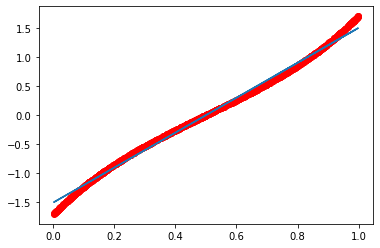

In [ ]:
nb_epochs = 50
SAG = SAGRegressor(lambada=0.01, eta=0.0001)
SAG.fit(X_exp,Y_exp,epochs=nb_epochs)
print('w = ', SAG.w,' et b = ',SAG.b)

print('Erreur moyenne = ', sum(abs(Y_exp - SAG.predict(X_exp))/len(Y_exp)))
plt.figure
plt.plot(X_exp,Y_exp,"ro")
plt.plot(X_exp,SAG.predict(X_exp))
plt.show()

##### 2. Tracez l’évolution de l’erreur quadratique en fonction des époques et en fonction des hyper-paramètres λ et η.

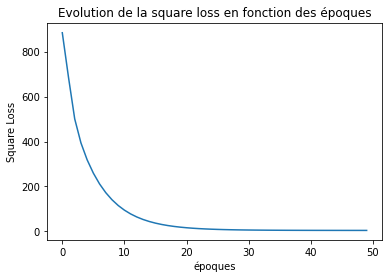

In [ ]:
plt.figure
plt.plot(np.arange(nb_epochs),SAG.squareloss)
plt.title('Evolution de la square loss en fonction des époques')
plt.xlabel('époques')
plt.ylabel('Square Loss')
plt.show()

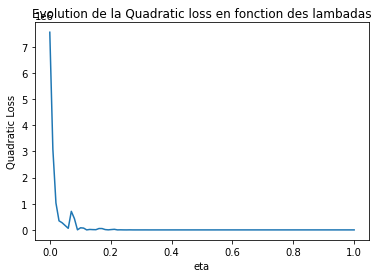

In [ ]:
squareloss = []
lambada_range = np.linspace(0.0001, 1, 100)
for lambada_local in lambada_range:
  SAG = SAGRegressor(lambada = lambada_local)
  SAG.fit(X_exp,Y_exp)
  squareloss.append(SAG.square_loss(X_exp,Y_exp))

plt.figure
plt.plot(lambada_range, squareloss)
plt.title('Evolution de la Quadratic loss en fonction des lambadas')
plt.xlabel('eta')
plt.ylabel('Quadratic Loss')
plt.show()

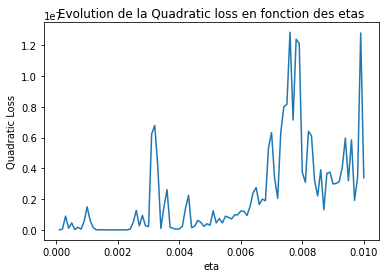

In [ ]:
squareloss = []
eta_range = np.linspace(0.0001, 0.01, 100)
for eta_local in eta_range:
  SAG = SAGRegressor(eta = eta_local)
  SAG.fit(X_exp,Y_exp)
  squareloss.append(SAG.square_loss(X_exp,Y_exp))

plt.figure
plt.plot(eta_range, squareloss)
plt.title('Evolution de la Quadratic loss en fonction des etas')
plt.xlabel('eta')
plt.ylabel('Quadratic Loss')
plt.show()

##### 3. Utilisez votre régresseur pour prédire le prix des biens dans le jeu de données *housedata*. Quelles performances obtenez-vous ? Pour quels paramètres, avec quels prétraitements (normalisation, standardisation, PCA, etc) ?


In [ ]:
SAG = SAGRegressor(lambada=0.5, eta=0.00001)
SAG.fit(X_train,Y_train,epochs=100)
print('w = ', SAG.w,' et b = ',SAG.b)

print('Erreur moyenne = ', sum(abs(Y_train - SAG.predict(X_train))/len(Y_train)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in matmul


w =  [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan]  et b =  nan
Erreur moyenne =  nan


Les données non standardisées sont trop grandes, le calcul est inutile.

In [ ]:
SAG = SAGRegressor(lambada=0.5, eta=0.00001)
SAG.fit(X_train_std,Y_train_std, epochs = 100)
print('w = ', SAG.w,' et b = ',SAG.b)

print('Erreur moyenne = ', sum(abs(Y_train_std - SAG.predict(X_train_std))/len(Y_train_std)))

w =  [-0.0082902   0.00276114 -0.00455003  0.01242639  0.01185607 -0.01167304
 -0.00081443 -0.00232741  0.00645318 -0.03643787 -0.00249956 -0.00343097
  0.02522245  0.01029892  0.10333116  0.00397812  0.12187266  0.02096749
  0.04677329  0.06689734  0.05065716  0.02667224  0.05459384  0.05752822
  0.04313117  0.04855078  0.01675631  0.10640407  0.008185    0.1143268
  0.06509237  0.10056618  0.11890757  0.03176096  0.08883936  0.0174717
  0.06963562  0.00608487  0.03217332  0.02037066  0.05515017  0.00307307
  0.00517134  0.04455227  0.11595155  0.11488413  0.10457417  0.05836927
  0.2618157   0.09329895  0.00368396  0.05504743  0.01010728  0.02964434
  0.04016153  0.05890296  0.02165789]  et b =  -0.00868443269682502
Erreur moyenne =  0.4307475767893956


In [ ]:
SAG = SAGRegressor(lambada=0.5, eta=0.00001)
SAG.fit(X_train_PCA,Y_train,epochs=100)
print('w = ', SAG.w,' et b = ',SAG.b)

print('Erreur moyenne = ', sum(abs(Y_train - SAG.predict(X_train_PCA))/len(Y_train)))

w =  [ 1.00436136e+05  9.78769504e+04 -3.53886862e+04  2.70702967e+04
 -3.64573016e+03  2.42459340e+04 -1.60579719e+04  1.40162024e+04
 -3.02017594e+04  2.90895365e+04  5.24301138e+03 -1.63400688e+04
  3.61242781e+04  1.59462542e+04  1.36185948e+04  5.33427488e+03
 -6.64350886e+03 -1.65891265e+04  8.90990855e+03  1.92069865e+03
  4.66088277e+03  5.36783209e+03 -8.01160124e+03 -1.72495265e+03
  2.80278858e+02  2.02853328e+04 -5.14883062e+03  8.61179561e+03
 -1.89049858e+03 -5.97664867e+03  1.17758099e+04  1.41892882e+04
 -4.84953399e+03 -4.84107991e+03  1.99255860e+04  8.48751845e+03
 -1.19146520e+04 -1.05801393e+04 -1.25176029e+04  1.22352970e+04
 -1.63633898e+03  3.04382589e+03  7.28039981e+03  5.86747346e+04
 -1.17444072e+04 -1.16437365e+04 -3.13033320e+04 -1.42316073e+04
  4.83540486e+04  4.10320591e+04  2.49431034e+03 -5.61508536e+04
 -7.70721655e+04  2.59938216e+04 -2.57872426e+04  8.15959130e-02
  9.30545101e-02]  et b =  533996.4226813441
Erreur moyenne =  140787.18912479086


Les résultats sont plutôt bons avec PCA, seulement 140 000\$ d'écart moyen pour un prix moyen dans les 550k\$. L'algorithme fournit en tous cas un indicatuer raisonnable, et ce malgré un nombre restreint de données.

# Cas Non Linéaire




Nous nous intéressons maintenant au cas non linéaire grâce à l’introduction de fonctions noyaux :
$\displaystyle min_{w} \frac{\lambda}{2} ||w||^2 + \frac{1}{n} \sum_i l(y_i,f(x_i))$  
avec  
$f(x) = <w, φ(x)>$  
tel que $φ(·)$ correspond à la fonction d’injection d’un noyau $k(·, ·) = <φ(·), φ(·)>$. Grâce au kernel trick, la fonction $φ(·)$ n’est pas nécessairement connue. Dans ce sujet, on utilisera les noyaux suivants :  
— Linéaire : $k(x1, x2) = <x1, x2>$  
— Polynomial d’ordre p : $k(x1, x2) = <x1, x2>^p$  
— Gaussien : $k(x1, x2) = exp(−γ||x1 − x2||^2)$  
Pour résoudre le problème d’optimisation, il faut passer par une méthode duale. Une méthode duale obtient une fonction de prédiction utilisant le noyau de la forme suivante (théorème des représentants) :  
$f(x) = \sum_i α_iy_ik(x_i, x)$  
Nous allons pour cela utiliser l’algorithme SDCA décrit dans :  
Shalev-Shwartz, Shai, and Tong Zhang. *”Stochastic dual coordinate ascent methods for regularized loss minimization.”* Journal of Machine Learning Research 14, no. Feb (2013) : 567-599.

## Classification
Programmez l’algorithme SDCA en python pour le *hinge loss* $(l(x, y) = max(0, 1 − yf(x))$.

In [ ]:
def kernel_polynomial(X,order):
  K = np.zeros((X.shape[0],X.shape[0]))
  for i in range(len(K)):
    for j in range(len(K)):
      K[i,j] = ((X[i].T).dot(X[j]))**order
  return K

def kernel_gaussian(X,gamma):
  K = np.zeros((X.shape[0],X.shape[0]))
  for i in range(len(K)):
    for j in range(len(K)):
      K[i,j] = np.exp(-gamma * np.linalg.norm(X[j] - X[i],2)**2)
  return K

In [ ]:
class SDCAClassifier ():
  def __init__ (self, kernel, C=1.0, order=1, gamma=0):
    self.kernel = kernel
    self.C = C
    self.gamma = gamma
    self.order = order
    self.alpha = None
    self.X = None
    self.y = None


  def fit (self, X , Y , epochs = 5 ) : 
    self.X = X
    self.Y = np.reshape(Y,(len(Y),))
    n,m = X.shape
    # cas debut, initialisation random
    if self.alpha is None:
      self.alpha = np.zeros(n)
    # algo SDCA
    for k in range(epochs):
      for i in np.random.permutation(n):
        # fonction de prediction
        fi = (self.Y[i]*(self.Y*self.alpha.T)@self.kernel[:,i])
        self.alpha[i] += (1-fi)/(self.kernel[i,i])
        # hinge loss
        self.alpha[i] = max(0, min(self.C,self.alpha[i]))


  def predict (self, X):
    if self.gamma ==0 :
      K = kernel_polynomial(X,self.order)
    else:
      K = kernel_gaussian(X, self.gamma)
    # maintenant on affecte la valeur classifiee
    Y = np.zeros(len(X))
    for i in range(Y.shape[0]):
      if (self.Y*self.alpha.T@K[:, i])>0:
        Y[i] = 1
      else:
        Y[i] = -1
    return Y

##### 1. Testez votre implémentation sur un cas jouet à 1 seule dimension, telle que
$$
y = \left\{
    \begin{array}{ll}
        1 & \mbox{si } 0 ≤ x < 0.25 ou 0.5 ≤ x < 0.75 \\
        -1 & \mbox{sinon.}
    \end{array}
\right.
$$  
En particulier, produisez une animation de visualisation qui permet de voir l’évolution des données,
des $α_i$ et de la fonction de prédiction $f(x)$ au cours des itérations

In [ ]:
X_creneau = np.sort(np.random.rand(1000,1))
Y_creneau = -np.ones(X_creneau.shape[0])
for i in range(X_creneau.shape[0]):
  if(X_creneau[i]>=0 and X_creneau[i]<0.25 or X_creneau[i]>=0.5 and X_creneau[i]<0.75):
    Y_creneau[i] = 1

In [ ]:
gamma = 10
K = kernel_gaussian(X_creneau,gamma)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=0, gamma=gamma)
SDCA.fit(X_creneau,Y_creneau, epochs = 20)

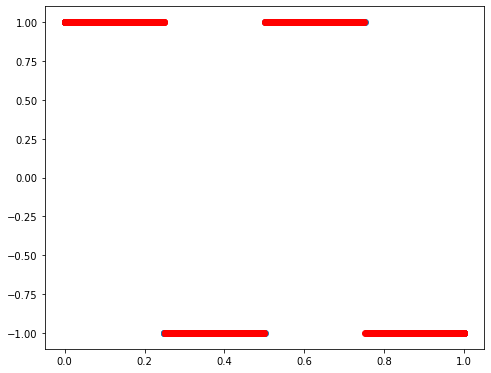

In [ ]:
plt.figure
plt.plot(X_creneau,Y_creneau,"ro")
plt.scatter(X_creneau,SDCA.predict(X_creneau))
plt.show()

In [ ]:
gamma = 10
order = 0
K = kernel_gaussian(X_creneau,gamma)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_creneau,Y_creneau, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_creneau,Y_creneau, epochs)
    point.set_data(X_creneau, SDCA.predict(X_creneau))
    line.set_data(X_creneau,Y_creneau)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

##### 2. Produisez plusieurs animations de ce type pour différents noyaux et différentes valeurs de C et analysez les différents comportements observés.

In [ ]:
gamma = 0
order = 2
K = kernel_polynomial(X_creneau,order)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_creneau,Y_creneau, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_creneau,Y_creneau, epochs)
    point.set_data(X_creneau, SDCA.predict(X_creneau))
    line.set_data(X_creneau,Y_creneau)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim
print('Kernel polynomial d\'ordre 2')

In [ ]:
gamma = 0
order = 3
K = kernel_polynomial(X_creneau,order)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_creneau,Y_creneau, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_creneau,Y_creneau, epochs)
    point.set_data(X_creneau, SDCA.predict(X_creneau))
    line.set_data(X_creneau,Y_creneau)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

print('Kernel polynomial d\'ordre 3')

In [ ]:
gamma = 10
order = 0
K = kernel_gaussian(X_creneau,gamma)

SDCA = SDCAClassifier(kernel = K, C = 100, order=order, gamma=gamma)
SDCA.fit(X_creneau,Y_creneau, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_creneau,Y_creneau, epochs)
    point.set_data(X_creneau, SDCA.predict(X_creneau))
    line.set_data(X_creneau,Y_creneau)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

print('Avec C = 100')

In [ ]:
gamma = 10
order = 0
K = kernel_gaussian(X_creneau,gamma)

SDCA = SDCAClassifier(kernel = K, C = 10, order=order, gamma=gamma)
SDCA.fit(X_creneau,Y_creneau, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_creneau,Y_creneau, epochs)
    point.set_data(X_creneau, SDCA.predict(X_creneau))
    line.set_data(X_creneau,Y_creneau)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

print('Avec C = 10')

##### 3. Utilisez votre algorithme pour classifier le jeu de données *housedata* en deux classes séparant les biens valant plus de \$460k de ceux de moins de \$460k. Quelles performances obtenez-vous ? Pour quels hyper-paramètres (C, noyau, époques, ...), avec quels prétraitements (normalisation, standardisation, PCA, etc) ?

In [ ]:
print('après standardisation')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('après PCA')

gamma = 10
order = 1
K = kernel_gaussian(X_train_PCA,gamma)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_train_PCA,Y_train_PCA, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_PCA,Y_train_PCA, epochs)
    point.set_data(X_train_PCA, SDCA.predict(X_train_PCA))
    line.set_data(X_train_PCA,Y_train_PCA)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec un noyeau Polynomial d\'ordre 2')

gamma = 0
order = 2
K = kernel_polynomial(X_train_std,order)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec un noyeau Polynomial d\'ordre 3')

gamma = 0
order = 3
K = kernel_polynomial(X_train_std,order)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec C = 100')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCAClassifier(kernel = K, C = 100, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec C = 10')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCAClassifier(kernel = K, C = 10, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec 60 époques')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCAClassifier(kernel = K, C = 1000, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 60)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

Les animations sont très longues à produire, mais on trouve de bonnes valeurs avec un noyeau Gaussien, C = 100, une vingtaine d'époques.
Attention à ne pas overfitter avec des noyeaux polynomiaux de haut degré !

## Régression
Créez une deuxième classe `class SDCARegressor` qui minimise l’erreur quadratique $l(y, x) = (y −f(x))^2$
au lieu du hinge loss

In [ ]:
class SDCARegressor ():
  def __init__ (self, kernel, C=1.0, order=1, gamma=0):
    self.kernel = kernel
    self.C = C
    self.order = order
    self.gamma = gamma
    self.alpha = None
    self.X = None
    self.y = None

  def fit(self, X, Y, epochs=5):
    self.X = X
    self.Y = np.reshape(Y,(len(Y),))
    n,m = X.shape
    # cas debut, initialisation random
    if self.alpha is None:
      self.alpha = np.zeros(n)
    # algo SDCA
    for k in range(epochs):
      for i in np.random.permutation(n):
        # fonction de prediction
        # pour une raison inconnue, il faut diviser sur la meme ligne
        fi = (self.Y[i] - (self.alpha.T)@self.kernel[:,i] - 0.5*self.alpha[i])/(0.5 + self.kernel[i,i]*self.C)
        # square loss
        self.alpha[i] += fi

  def predict (self, X):
    if self.gamma ==0 :
      K = kernel_polynomial(X,self.order)
    else:
      K = kernel_gaussian(X, self.gamma)
    # maintenant on affecte la valeur regressee
    return (self.alpha.T)@K

##### 1. Créez un cas jouet à 1 seule dimension correspondant à une fonction en dents de scie et produisez les mêmes visualisations que pour la classification, avec des analyses similaires.


In [ ]:
X_scie = np.random.rand(1000,1)
Y_scie = np.zeros(X_scie.shape[0])
for i in range(X_scie.shape[0]):
  if(X_scie[i]<0.2):
    Y_scie[i] = 5*X_scie[i]
  elif(X_scie[i]>=0.2 and X_scie[i]<0.4):
    Y_scie[i] = 2 - 5*X_scie[i]
  elif(X_scie[i]>=0.4 and X_scie[i]<0.6):
    Y_scie[i] = -2 + 5*X_scie[i]
  elif(X_scie[i]>=0.6 and X_scie[i]<0.8):
    Y_scie[i] = 4 - 5*X_scie[i]
  elif(X_scie[i]>=0.8 and X_scie[i]<1):
    Y_scie[i] = -4 + 5*X_scie[i]

In [ ]:
gamma = 10
K = kernel_gaussian(X_scie,gamma)

SDCA = SDCARegressor(kernel = K, C = 50, order=0, gamma=gamma)
SDCA.fit(X_scie,Y_scie, epochs = 5)

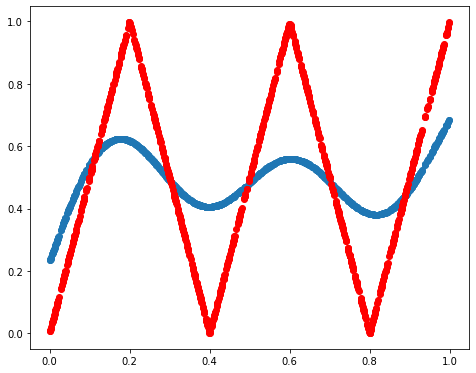

In [ ]:
plt.figure
plt.plot(X_scie,Y_scie,"ro")
plt.scatter(X_scie,SDCA.predict(X_scie))
plt.show()

##### 2. Utilisez votre régresseur pour prédire le prix des biens dans le jeu de données *housedata*. Quelles performances obtenez vous ? Pour quels hyper-paramètres, avec quels prétraitements (normalisation, standardisation, PCA, etc) ?

In [ ]:
print('après standardisation')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCARegressor(kernel = K, C = 50, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 3)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('après PCA')

gamma = 10
order = 1
K = kernel_gaussian(X_train_PCA,gamma)

SDCA = SDCARegressor(kernel = K, C = 50, order=order, gamma=gamma)
SDCA.fit(X_train_PCA,Y_train_PCA, epochs = 3)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_PCA,Y_train_PCA, epochs)
    point.set_data(X_train_PCA, SDCA.predict(X_train_PCA))
    line.set_data(X_train_PCA,Y_train_PCA)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec un noyeau Polynomial d\'ordre 2')

gamma = 0
order = 2
K = kernel_polynomial(X_train_std,order)

SDCA = SDCARegressor(kernel = K, C = 50, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 3)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec un noyeau Polynomial d\'ordre 3')

gamma = 0
order = 3
K = kernel_polynomial(X_train_std,order)

SDCA = SDCARegressor(kernel = K, C = 50, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 3)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec C = 100')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCARegressor(kernel = K, C = 100, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec C = 10')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCARegressor(kernel = K, C = 10, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 20)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

In [ ]:
print('Avec 60 époques')

gamma = 10
order = 1
K = kernel_gaussian(X_train_std,gamma)

SDCA = SDCARegressor(kernel = K, C = 50, order=order, gamma=gamma)
SDCA.fit(X_train_std,Y_train_std, epochs = 60)

# animation !
plt.rcParams['figure.figsize'] = [20/2.54, 16/2.54]
# definition
fig, ax = plt.subplots()
plt.close()
# limites de la fenetre
ax.set_xlim(( 0, 1))
ax.set_ylim((-1.2, 1.2))
# on cree els deux objets qui nous interessent
line, = ax.plot([], [], "ro")
point, = ax.plot([], [], 'g*')

def animate(i): 
    SDCA.fit(X_train_std,Y_train_std, epochs)
    point.set_data(X_train_std, SDCA.predict(X_train_std))
    line.set_data(X_train_std,Y_train_std)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=None,
                             frames=20, interval=10, blit=False)
# Note: below is the part which makes it work on Colab
rc('animation', html='jshtml')
anim

Conclusion du même type que pour la Classification. Il faut prendre garde à ce que régler les hyper-paramètres trop précisément ne conduise pas à simplement overfitter les données, ce qui est sans intérêt. Régler des "bons" hyper-paramètres relève de l'étude de chaque champ d'application, c'est pourquoi la plupart des bilbiothèques leur assignent une valeur de façon automatique, mais leur laisse accès.